In [2]:
!pip install kaggle  torchinfo torchsummary -q

In [3]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 100 not upgraded.


In [4]:
# !mkdir ~/.kaggle

In [5]:
# !cp kaggle.json ~/.kaggle/

In [6]:
# !chmod 600 /root/.kaggle/kaggle.json

In [7]:
# !kaggle competitions download -c histopathologic-cancer-detection

In [8]:
%%bash
pip install opencv-python -q
pip install torchsummary

In [9]:
# !rm -rf data imgs && mkdir data imgs && unzip -q ./histopathologic-cancer-detection.zip -d data

In [10]:
#Only for Colab

# from google.colab import drive
# drive.mount('/content/drive')

## **Project Description**

This project focuses on developing a machine learning model to classify small pathology images for the detection of metastatic cancer. The core problem is to accurately identify whether the central 32x32 pixel region of a given image patch contains tumor tissue. A positive label signifies the presence of tumor tissue, while a negative label indicates its absence.

The dataset utilized is a modified version of the PatchCamelyon (PCam) benchmark dataset, specifically curated from Kaggle to ensure no duplicate images. The objective is to build a robust classification system that can process these histopathologic scans of lymph node sections and predict the presence of malignant tissue. The performance of the developed model will be evaluated based on the Area Under the Receiver Operating Characteristic (ROC) curve, a standard metric for binary classification tasks that assesses the model's ability to distinguish between the two classes across various threshold settings.

In [11]:
import numpy as np
import pandas as pd
import os
import cv2

## **DATASET**


The data used in this project is a slightly modified version of the [PatchCamelyon (PCam)](https://github.com/basveeling/pcam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on [kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/data) does not contain duplicates).We have otherwise maintained the same data and splits as the PCam benchmark.

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

Kaggle Link: https://www.kaggle.com/c/histopathologic-cancer-detection/data \\
 Original Dataset Link (Github):https://github.com/basveeling/pcam
 
 Data Folder Structure
 Data is composed of folders like train,test,train_labels.csv and sample_submission.csv
 Both test and train folders contain TIFF (Tag Image File Format). Contain `57459` items for test and `220026` items for train.
 Check the following for exploration of  `train_labels.csv`.


In [12]:
%%bash
tree -L 1 data
ls -l ./data/test | wc -l
ls -l ./data/train | wc -l

data
├── sample_submission.csv
├── test
├── train
└── train_labels.csv

2 directories, 2 files
57459
220026


In [13]:
data = pd.read_csv('./data/train_labels.csv')
trainPath = './data/train'
testPath =  './data/test'


In [14]:
print(data.head().to_markdown())

|    | id                                       |   label |
|---:|:-----------------------------------------|--------:|
|  0 | f38a6374c348f90b587e046aac6079959adf3835 |       0 |
|  1 | c18f2d887b7ae4f6742ee445113fa1aef383ed77 |       1 |
|  2 | 755db6279dae599ebb4d39a9123cce439965282d |       0 |
|  3 | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08 |       0 |
|  4 | 068aba587a4950175d04c680d38943fd488d6a9d |       0 |


In [15]:
data['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


**DataFrame Summary:**

Total Entries: *220,025*\
Columns: *2*\
Column Details:

**id**

Non-Null Count: *220,025*\
Data Type: *object*\
Description: Likely a unique identifier for each entry.

**label**

Non-Null Count: *220,025*\
Data Type: *int64*\
Description: Represents a label or category associated with each id. It’s an integer value indicating class or group membership.\
Memory Usage: Approximately 3.4 MB

**Data Types Overview:**

int64: 1 column (label)\
object: 1 column (id)

This Dataset doesn't contain **null values** for both Columns.

## **Exploratory Data Analysis (EDA)**

Exploratory Data Analysis (EDA) is a crucial step in any data science project. It involves analyzing data sets to summarize their main characteristics, often with visual methods. EDA helps to understand the data's properties, identify patterns, spot anomalies, test hypotheses, and check assumptions with the help of statistical graphics and other data visualization methods. It's an iterative process that helps uncover insights and guides subsequent steps like data preprocessing and model selection.

In this EDA section, we perform several key analyses to gain insights into our histopathologic cancer detection dataset:

1.  **Label Distribution:** We start by visualizing the distribution of labels (malignant vs. non-malignant) using a histogram to understand the class balance in our dataset.
2.  **Image Preview:** We display sample images from both the "malignant" (label 1) and "non-malignant" (label 0) classes to get a visual understanding of the data. This helps in observing the general appearance of the image patches.
3.  **Image Dimensions:** We confirm and display the dimensions (width, height, and number of color channels) of the images to ensure consistency across the dataset.
4.  **Pixel Intensity Analysis:** We delve deeper by plotting pixel intensity histograms for sample images from both classes to understand the distribution of pixel values across color channels (Red, Green, Blue). This helps identify dominant pixel ranges and overall brightness characteristics. We also check and compare the minimum and maximum pixel values across several samples to assess data consistency.
5.  **Image Similarity (Mean Squared Error - MSE):** To get a quantitative sense of how similar images are within the same class and between different classes, we calculate the Mean Squared Error (MSE). This provides a basic pixel-wise similarity metric, helping to understand initial separability, though complex features are often more indicative for such tasks.

**Label Distribution:**

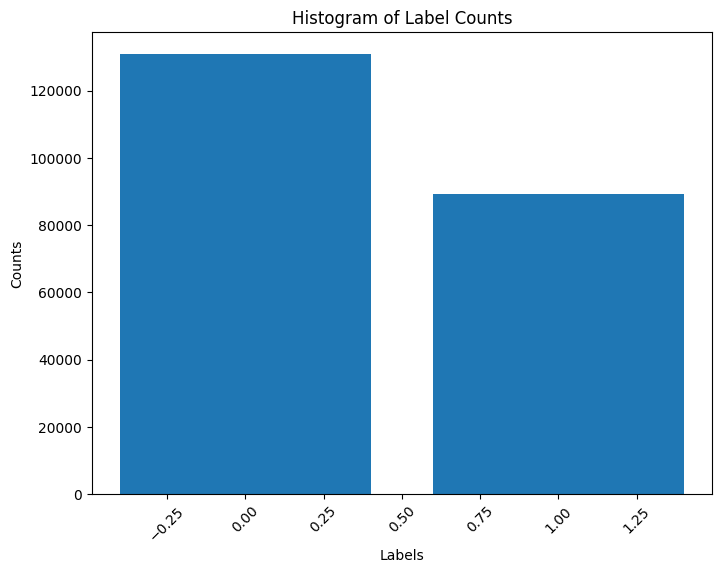

In [17]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
value_counts = data['label'].value_counts()

plt.figure(figsize=(8,6))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Histogram of Label Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()


We will perform random sampling for training and validation and will also perform image augmentation later so don't have to worry about that much for data imbalancing.

**Image Preview**

Let's also visualise the dataset images:

**NON-MALIGNANT CASES (LABEL: 0)**, outligned with green colour\
**ALIGNANT CASES      (LABEL: 1)**, outligned with red colour

In [18]:
#Splitting the dataset into two part malignant and non-malignant
imgpath ="./data/train/" # training data is stored in this folder
malignant = data.loc[data['label']==1]['id'].values    # get the ids of malignant cases
normal = data.loc[data['label']==0]['id'].values       # get the ids of the normal cases

print('normal ids')
print(normal[0:3],'\n')

print('malignant ids')
print(malignant[0:3])

normal ids
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08'] 

malignant ids
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f']


In [19]:
# %%
#Helper function to read image
# import cv2 # Already imported at the top of the EDA section
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return bgr_img

In [20]:
malignant

array(['c18f2d887b7ae4f6742ee445113fa1aef383ed77',
       'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da',
       '7f6ccae485af121e0b6ee733022e226ee6b0c65f', ...,
       '309210db7f424edbc22b2d13bf2fa27518b18f5c',
       'd4b854fe38b07fe2831ad73892b3cec877689576',
       'a81f84895ddcd522302ddf34be02eb1b3e5af1cb'], dtype=object)

Text(0, 0.5, 'Negative samples')

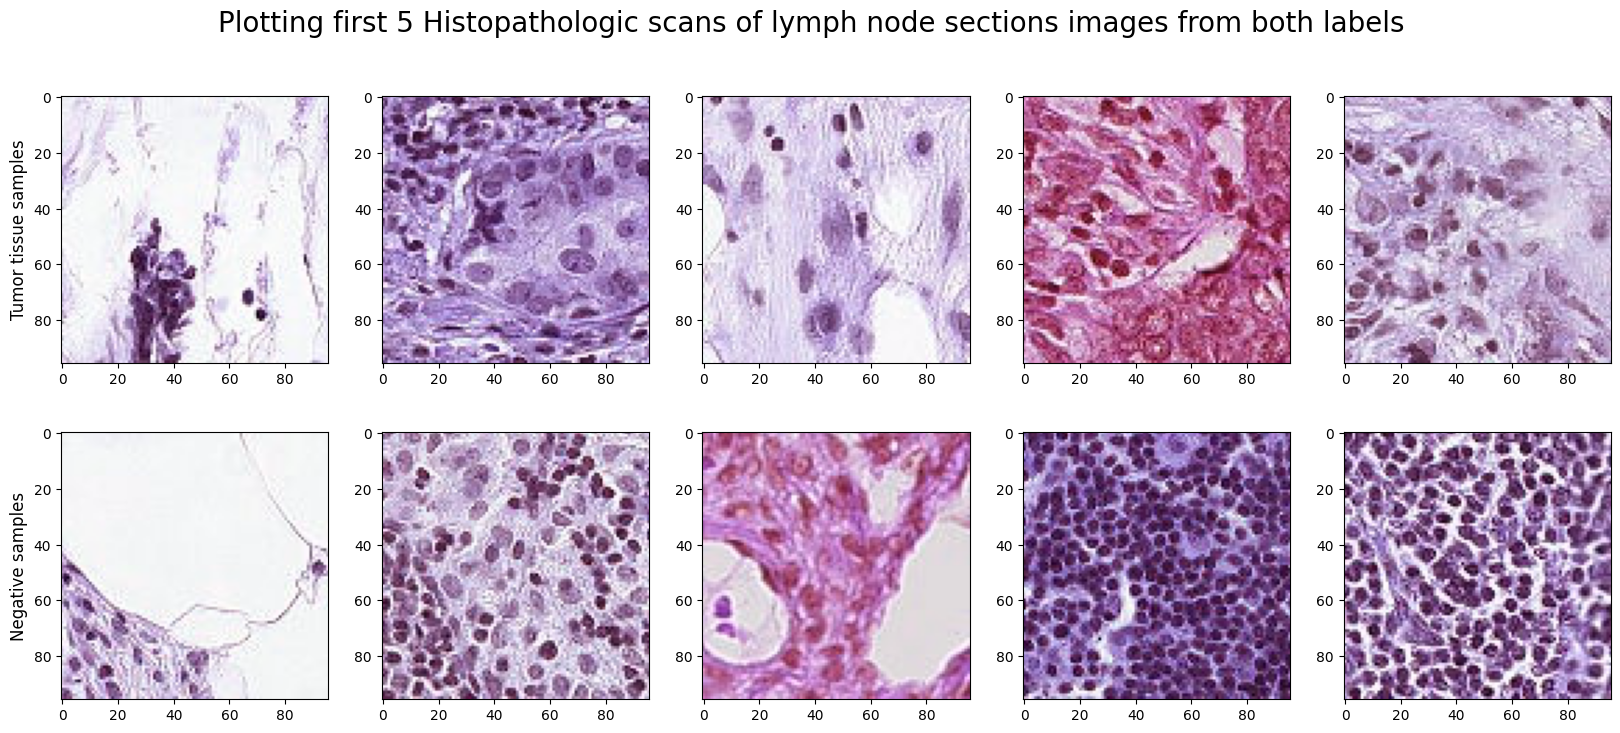

In [21]:
#Plotting first 5 images from both labels (malignant and non-malignant)

import os
import matplotlib.patches as patches

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Plotting first 5 Histopathologic scans of lymph node sections images from both labels',fontsize=20)
# Negatives
for i, idx in enumerate(malignant[0:5]):
    path = os.path.join(imgpath, idx)
    ax[0,i].imshow(readImage(path + '.tif'))

ax[0,0].set_ylabel('Tumor tissue samples', size='large')

# Positives
for i, idx in enumerate(normal[0:5]):
    path = os.path.join(imgpath, idx)
    ax[1,i].imshow(readImage(path + '.tif'))

ax[1,0].set_ylabel('Negative samples', size='large')

In [22]:
print("Image dimensions of non-malignant")
print(readImage(imgpath+normal[0]+'.tif').shape)
print("\nImage dimensions of malignant")
print(readImage(imgpath+malignant[0]+'.tif').shape)


Image dimensions of non-malignant
(96, 96, 3)

Image dimensions of malignant
(96, 96, 3)



The dimensions of images for both (malignant and non-malignant) are **(96,96)** with **3 channels rgb** images.


#### **Enhanced EDA: Pixel Intensity Analysis**
Let's explore the distribution of pixel intensities for a few sample images from both classes to understand their value ranges.


--- Malignant Image Pixel Intensity Distribution ---


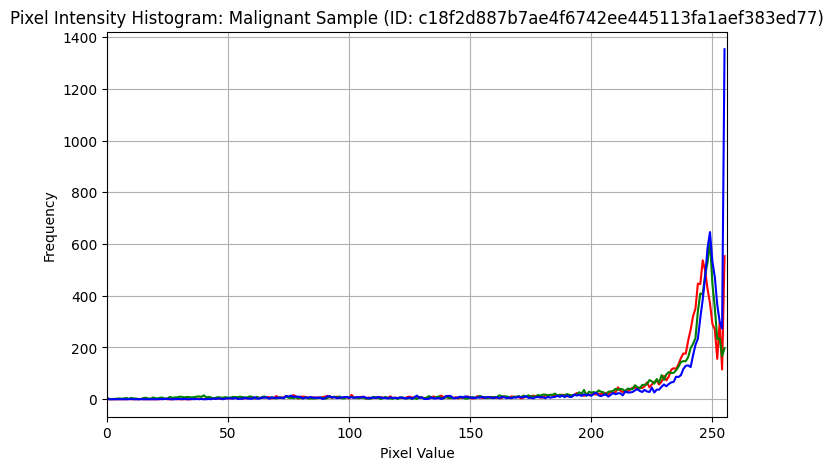

Malignant Image - Min Pixel Value: 0, Max Pixel Value: 255

--- Normal Image Pixel Intensity Distribution ---


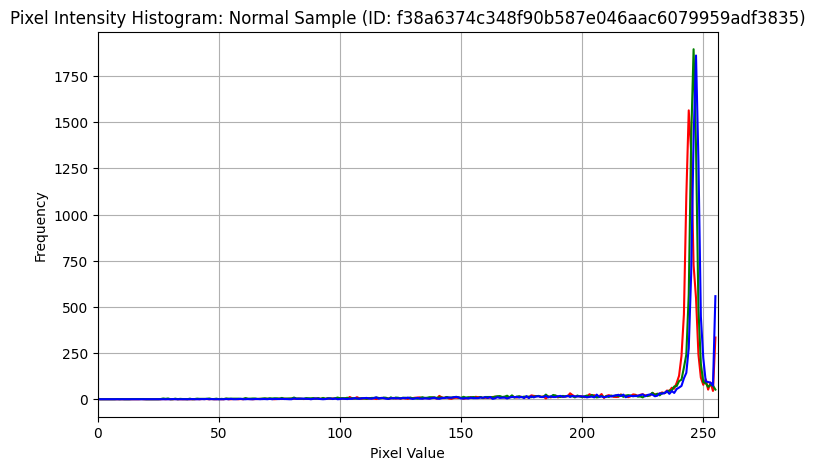

Normal Image - Min Pixel Value: 0, Max Pixel Value: 255

--- Comparing Pixel Value Ranges Across More Samples ---
Label | Image ID                           | Min Pixel | Max Pixel
------|------------------------------------|-----------|----------
1     | c18f2d887b7ae4f6742ee445113fa1aef383ed77 |         0 |      255
0     | f38a6374c348f90b587e046aac6079959adf3835 |         0 |      255
1     | a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da |         0 |      255
0     | 755db6279dae599ebb4d39a9123cce439965282d |         0 |      255
1     | 7f6ccae485af121e0b6ee733022e226ee6b0c65f |         5 |      255
0     | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08 |        18 |      255
1     | c3d660212bf2a11c994e0eadff13770a9927b731 |         0 |      255
0     | 068aba587a4950175d04c680d38943fd488d6a9d |         0 |      255
1     | 94fa32b29cc1c00403176c0795fffa3cfaa0f20e |         6 |      255
0     | acfe80838488fae3c89bd21ade75be5c34e66be7 |         0 |      255


In [23]:
# Function to plot pixel intensity histograms for an image
def plot_pixel_intensity_histogram(image, title):
    plt.figure(figsize=(8, 5))
    for i, color in enumerate(['red', 'green', 'blue']):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.title(f'Pixel Intensity Histogram: {title}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
# Select a few sample image paths (e.g., one malignant, one normal)
sample_malignant_path = os.path.join(imgpath, malignant[0] + '.tif')
sample_normal_path = os.path.join(imgpath, normal[0] + '.tif')

# Read the images (OpenCV reads as BGR, but we'll work with the raw values)
malignant_img_bgr = cv2.imread(sample_malignant_path)
normal_img_bgr = cv2.imread(sample_normal_path)


print("--- Malignant Image Pixel Intensity Distribution ---")
plot_pixel_intensity_histogram(malignant_img_bgr, f'Malignant Sample (ID: {malignant[0]})')
print(f"Malignant Image - Min Pixel Value: {malignant_img_bgr.min()}, Max Pixel Value: {malignant_img_bgr.max()}")


print("\n--- Normal Image Pixel Intensity Distribution ---")
plot_pixel_intensity_histogram(normal_img_bgr, f'Normal Sample (ID: {normal[0]})')
print(f"Normal Image - Min Pixel Value: {normal_img_bgr.min()}, Max Pixel Value: {normal_img_bgr.max()}")

# Compare min/max pixel values across a few more samples
print("\n--- Comparing Pixel Value Ranges Across More Samples ---")
num_samples_to_check = 5
print("Label | Image ID                           | Min Pixel | Max Pixel")
print("------|------------------------------------|-----------|----------")

for i in range(num_samples_to_check):
    mal_id = malignant[i]
    norm_id = normal[i]

    mal_path = os.path.join(imgpath, mal_id + '.tif')
    norm_path = os.path.join(imgpath, norm_id + '.tif')

    mal_img = cv2.imread(mal_path)
    norm_img = cv2.imread(norm_path)

    print(f"1     | {mal_id} | {mal_img.min():9d} | {mal_img.max():8d}")
    print(f"0     | {norm_id} | {norm_img.min():9d} | {norm_img.max():8d}")




**Observations from Pixel Intensity Analysis:**
* The histograms show the distribution of pixel values for each color channel (Red, Green, Blue). We can observe if certain intensity ranges are more prevalent for specific classes.
* By checking the min and max pixel values, we can confirm that the images generally utilize the full 0-255 range, which is standard for 8-bit images. The consistency in min/max values across samples suggests a uniform intensity scale in the dataset.


### **Histogram Interpretation (Pixel Intensity Analysis)**

* **Axis Explanation:**
    * The **X-axis (Pixel Value)** ranges from 0 to 255, representing the intensity of each color channel (Red, Green, Blue) in the image. A value of 0 is black, and 255 is white.
    * The **Y-axis (Frequency)** indicates how many pixels in the image have a particular intensity value.

* **General Shape and Observations:**
    * Both the malignant and the normal histograms show a **heavy concentration of pixels towards the higher end of the pixel value spectrum (approaching 255)**. This is visible as a significant spike around the 240-255 range for all three color channels (Red, Green, Blue).
    * This strong peak near 255 suggests that a large portion of the images, for both malignant and normal samples, consists of very bright (close to white) areas. This is common in histopathology images where much of the slide background or unstained tissue might appear very bright.
    * There's also a smaller frequency of pixels across the lower and middle ranges (0-200), indicating some darker or more varied colored regions, likely corresponding to stained tissue structures.

* **Comparison Between Malignant and Normal Samples:**
    * Visually, the overall shape and peak locations of the histograms for the malignant sample and the normal sample are quite similar. Both exhibit the characteristic high frequency of bright pixels.
    * This similarity suggests that, at a broad pixel intensity level, there isn't an immediately obvious distinguishing feature between the classes based solely on these global histograms. The "texture" or "structure" differences that define tumor tissue versus normal tissue are likely more subtle and involve spatial arrangements of pixels, rather than just their overall intensity distribution.

* **Pixel Value Range Consistency:**
    * The output comparing pixel value ranges across multiple samples confirms that almost all images, regardless of their label, utilize the full 0-255 pixel intensity range.
    * This consistency (e.g., Min Pixel 0, Max Pixel 255 for many images) indicates that the images are consistently scaled and no significant clipping or unusual normalization was applied before this analysis. This is beneficial for subsequent preprocessing steps like normalization.

In summary, the pixel intensity histograms reveal that both malignant and normal pathology images are predominantly bright, with a large number of pixels concentrated at the higher intensity values. While these global histograms don't immediately highlight clear differences between the classes, they provide a fundamental understanding of the dataset's pixel value characteristics.

#### **Enhanced EDA: Image Similarity (Simple Metric)**
A simple way to get an idea of image similarity within and between classes is to calculate the Mean Squared Error (MSE) between image pixel values. Lower MSE indicates higher similarity.


In [24]:
# %%
# Function to calculate MSE between two images
def calculate_mse(imageA, imageB):
    # The 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1] * imageA.shape[2]) # Divide by total pixels and channels
    return err

# Select a few images for comparison
# One malignant image to itself (for baseline)
img1_mal_path = os.path.join(imgpath, malignant[0] + '.tif')
img1_mal = cv2.imread(img1_mal_path)

# Another malignant image
img2_mal_path = os.path.join(imgpath, malignant[1] + '.tif')
img2_mal = cv2.imread(img2_mal_path)

# One normal image
img1_norm_path = os.path.join(imgpath, normal[0] + '.tif')
img1_norm = cv2.imread(img1_norm_path)

# Another normal image
img2_norm_path = os.path.join(imgpath, normal[1] + '.tif')
img2_norm = cv2.imread(img2_norm_path)

print("--- Image Similarity (Mean Squared Error) ---")

# Malignant vs. Malignant
mse_mal_mal = calculate_mse(img1_mal, img2_mal)
print(f"MSE between Malignant Image 1 and Malignant Image 2: {mse_mal_mal:.2f}")

# Normal vs. Normal
mse_norm_norm = calculate_mse(img1_norm, img2_norm)
print(f"MSE between Normal Image 1 and Normal Image 2: {mse_norm_norm:.2f}")

# Malignant vs. Normal
mse_mal_norm = calculate_mse(img1_mal, img1_norm)
print(f"MSE between Malignant Image 1 and Normal Image 1: {mse_mal_norm:.2f}")


--- Image Similarity (Mean Squared Error) ---
MSE between Malignant Image 1 and Malignant Image 2: 9182.16
MSE between Normal Image 1 and Normal Image 2: 7452.80
MSE between Malignant Image 1 and Normal Image 1: 2856.91


**Interpretation of those MSE values:**

* **MSE between Malignant Image 1 and Malignant Image 2: 9182.16**: This value represents the similarity between two *different* images from the malignant class. A higher MSE indicates less pixel-wise similarity.
* **MSE between Normal Image 1 and Normal Image 2: 7452.80**: This shows the similarity between two *different* images from the normal class. Compared to the malignant-malignant MSE, this value is lower, suggesting that normal images might be slightly more similar to each other on a pixel level, although both are relatively high.
* **MSE between Malignant Image 1 and Normal Image 1: 2856.91**: This is the similarity between an image from the malignant class and an image from the normal class. Notably, this MSE value is significantly *lower* than the within-class MSE values (9182.16 and 7452.80).

**Observations from Image Similarity Analysis:**


* The Mean Squared Error (MSE) provides a quantitative measure of pixel-wise similarity. Lower MSE values indicate more similar images.
* Comparing MSE values between images of the same class (e.g., malignant-malignant or normal-normal) versus images from different classes (malignant-normal) can give an initial indication of class separability based on pixel content. Typically, images within the same class might show lower MSE values compared to images from different classes, although this is a very basic metric and does not capture high-level features.

## **Data Preprocessing and Plan of Analysis**

Data preprocessing is a critical step in the machine learning pipeline that involves transforming raw data into a clean and suitable format for model training. This stage is crucial because the quality of the data significantly impacts model performance. A well-defined plan of analysis, continuously informed by insights gained during Exploratory Data Analysis (EDA), outlines the strategic steps for preparing the data and subsequently using it to train, validate, and test the models.

In this section, we detail our data preprocessing methodology and articulate our overall plan for model development and evaluation, with each choice being a direct consequence of our initial data exploration.

### **Data Preprocessing Steps (Informed by EDA)**

Based on our Exploratory Data Analysis, which revealed the specific characteristics and challenges of the histopathologic image dataset, we've implemented the following preprocessing techniques:

1.  **Image Resizing and Normalization:**
    * **Informed by EDA:** Our EDA confirmed that all images are 96x96 pixels. While the problem focuses on a central 32x32px region, downsizing to 46x46 pixels is a strategic choice to **reduce computational load** during training, a decision made feasible by knowing the original dimensions and the task's focus. Normalization (scaling pixel values from 0-255 to 0-1 and then standardizing using mean/std) is applied because EDA showed pixel values ranging across the full spectrum (0-255); **neural networks train more effectively and converge faster with normalized inputs**, preventing large pixel values from dominating gradient calculations.

2.  **Data Augmentation:**
    * **Informed by EDA:** Although our dataset is substantial (220,025 entries), EDA provided a glimpse into the **variability of real-world pathology images**. To enhance the model's robustness and generalization to unseen, subtly varied medical images, data augmentation is a crucial component of our preprocessing plan. Techniques like **RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, RandomResizedCrop, and GaussianBlur** are applied to the training dataset. These transformations simulate minor variations in slide preparation, imaging conditions, or tumor presentation, thereby **increasing the diversity of our training data and reducing the risk of overfitting**, especially important for medical image tasks where acquiring massive, truly diverse datasets can be challenging.

3.  **Data Splitting (Train, Validation, Test Sets):**
    * **Informed by EDA:** Understanding the overall size and class distribution (from the label histogram in EDA) of the dataset is fundamental to creating robust splits. We partition the data into training, validation, and test sets. This ensures that the model is trained on one subset, tuned and monitored for generalization on a separate validation subset, and finally evaluated on a completely unseen test subset to provide an unbiased assessment of its performance. This structured splitting is vital to prevent data leakage and provide reliable performance metrics.

4.  **Batching and Data Loaders:**
    * **Informed by EDA:** Knowing the image dimensions and overall dataset size from EDA, we organize the processed data into efficient batches using PyTorch `DataLoader`s. This approach is adopted to **optimize memory usage and computational efficiency during training**, allowing the model to process subsets of data in parallel rather than loading all images into memory at once.

### **Modeling and Evaluation Plan:**

Following the careful preprocessing of our data, our strategic plan for model development and evaluation is as follows:

* **Training Deep Learning Models:** We will train two distinct deep learning models: a custom Convolutional Neural Network (CNN) tailored for this problem, and a fine-tuned, pre-trained DenseNet. This dual approach is chosen to **compare the efficacy of a purpose-built model against a state-of-the-art model leveraging transfer learning**, directly aiming to identify the best architecture for detecting the subtle patterns of tumor tissue identified as critical in our EDA.
* **Regular Monitoring and Optimization:** During the training phase, we will regularly evaluate model performance on the dedicated validation set. This crucial step allows us to monitor for signs of overfitting or underfitting by tracking loss and accuracy, and to dynamically adjust hyperparameters, such as the learning rate using schedulers, to ensure stable and optimal convergence.
* **Architectural Comparison and Selection:** A key part of our plan involves a quantitative and qualitative comparison of the trained models (custom CNN vs. DenseNet). This will include analyzing their respective performance metrics (loss, accuracy, AUC), convergence speeds, and generalization capabilities to determine which architecture is most suitable for accurate histopathologic cancer detection.
* **In-depth Results Analysis and Troubleshooting:** We commit to a thorough analysis of all experimental results. This includes delving into why certain models or configurations performed as they did, identifying their strengths and weaknesses, and detailing any troubleshooting steps undertaken during development to overcome challenges and improve outcomes.
* **Final Prediction and Submission:** The ultimate goal of this project is to apply the best-performing model to the unseen test dataset. We will generate predictions for these images and prepare them in the required format for submission, thus obtaining a final, unbiased evaluation of our solution's effectiveness in a real-world scenario.

In [25]:
import torch
from torch.utils.data import Dataset,random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, data_path,datafolder, transform=None,label_file='train_labels.csv'):

        #File Paths
        self.data_path = os.path.join(data_path,datafolder)
        self.img_idxs = os.listdir(self.data_path)
        self.dataSize=  100000
        #Image Idxes
        random_idxs = np.random.choice(np.arange(len(self.img_idxs)),
                                      self.dataSize,
                                      replace=False).tolist()
        sample_file_names = [self.img_idxs[x] for x in random_idxs]
        self.full_img_names = [os.path.join(imgpath, imgIdx) for imgIdx in sample_file_names ]


        #Labels
        labels_df_path = os.path.join(data_path,label_file)
        labels_df = pd.read_csv(labels_df_path)
        labels_df.set_index('id',inplace=True)

        # Need to remove '.tif'
        #'c24db5b9f11387eafd33883e161b4277ac7c14c3.tif'[:-4] -> c24db5b9f11387eafd33883e161b4277ac7c14c3
        self.labels = [labels_df.loc[idx[:-4]].values[0] for idx in sample_file_names]


        self.transform = transform

    def __len__(self):
        return len(self.full_img_names)

    def __getitem__(self, idx):
        # raw_image = readImage(self.full_img_names[idx])
        # image = self.transform(raw_image)
        # return {image, self.labels[idx]}

        image = Image.open(self.full_img_names[idx])  # Open Image with PIL
        image = self.transform(image) # Apply Specific Transformation to Image
        # print((f'image type :{type(image)} label: {self.labels[idx]}'))
        return image, self.labels[idx]

In [26]:
#Test Data Class
class TestData(Dataset):

    def __init__(self, data_dir, transform,data_type="train"):

        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # labels are in a csv file named train_labels.csv
        csv_filename="sample_submission.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [27]:
#Transform the image (numpy) into tensor
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

In [32]:
data_dir = './data/'
custom_imgDataset = CustomImageDataset(data_dir,'train',data_transformer) # Histopathalogic images


In [33]:
def read_img_pytensor(img_tensor,title):
  img_numpy = img_tensor.numpy()

  # 3. Convert from [C, H, W] to [H, W, C] format for visualization
  img_numpy = np.transpose(img_numpy, (1, 2, 0))

  # 4. Display the image using matplotlib
  plt.imshow(img_numpy)
  plt.title(title)
  plt.axis('off')
  plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


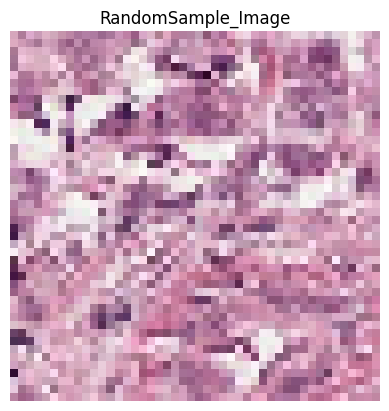

(None, tensor(0.0230), tensor(1.), torch.Size([3, 46, 46]))

In [34]:
from torchvision.io import read_image

#Displaying Image Resizing Cause Low Quaility for sure
#Normalized Ranges of Pixel values from (0,1) instead of (0,255)
#Resized Image to Pytorch Tensor (3,46,46) here pytorch use [C, H, W] instead of [H, W, C] format

img, label = custom_imgDataset[6]
read_img_pytensor(img,'RandomSample_Image'),torch.min(img), torch.max(img),img.shape

## **Dataset Splitting**

We will split new created custom_imgDataset Using Pytorch's [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) method


Random sampling ensures that both the training and validation sets have a representative distribution of classes. This is particularly important in imbalanced datasets like the one we have.


In [35]:
len_img=len(custom_imgDataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train,val=random_split(custom_imgDataset,
                             [len_train,len_val]) # random split 80/20

print("train dataset size:", len(train))
print("validation dataset size:", len(val))

train dataset size: 80000
validation dataset size: 20000


In [36]:
for i,(x,y) in enumerate(train):
  if i < 5:
    print(x.shape,y)
  else: break

#[print(x.shape,y) for i,(x,y) in enumerate(train) if i < 5 else break]

torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 1


### **Randomly Plotting Images from Train Set**

Randomly Selected Image indices:
 [ 4450 27079 37673 32879 16488 36286 16131 49248 64296  4621 44416 41082
 27470  9474 47967 59968 30427 14029 79317 57183 54289  2080 23433  3110
 18869 71573 45924 13154 16083 54850]


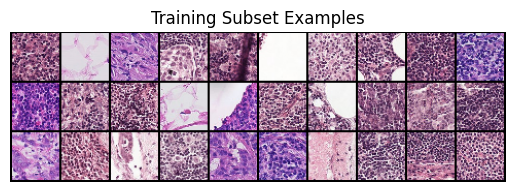

In [38]:
from torchvision.utils import make_grid

#Retrieve 30 image randomly from Train Set
grid_size=30
rnd_inds=np.random.randint(0,len(train),grid_size)
print("Randomly Selected Image indices:\n",rnd_inds)

rnd_train_imgs=[train[i][0] for i in rnd_inds]

rnd_train_imgs = make_grid(rnd_train_imgs, nrow=10, padding=2)
read_img_pytensor(rnd_train_imgs,'Training Subset Examples')

### **Randomly Plotting Images from Validation Set**

Randomly Selected Image indices:
 [11177  2577  7038 19923  6967  4324 10267 17775  5646 16959 19551  7859
  7071  3293 16865 17880 19298 15260  5950  1286 14111  8553 14760  3079
  1938 18533 14379 15464  6201 17771]


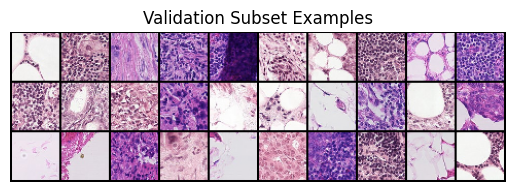

In [39]:
#Retrieve 30 image randomly from Validation Set
grid_size=30
rnd_inds=np.random.randint(0,len(val),grid_size)
print("Randomly Selected Image indices:\n",rnd_inds)

rnd_train_imgs=[val[i][0] for i in rnd_inds]

rnd_train_imgs = make_grid(rnd_train_imgs, nrow=10, padding=2)
read_img_pytensor(rnd_train_imgs,'Validation Subset Examples')

### **IMAGE ARGUMENTATION**


Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points.

**Why need to use data argumentation?**

- To prevent models from overfitting.
- The initial training set is too small.
- To improve the model accuracy.
- To Reduce the operational cost of labeling and cleaning the raw dataset.


**Limitations of Data Augmentation**
- The biases in the original dataset persist in the augmented data.
- Quality assurance for data augmentation is expensive.
- Research and development are required to build a system with advanced applications. For example, generating high-resolution images using GANs can be challenging.
- Finding an effective data augmentation approach can be challenging.

**Things included in Image Argumentation**

- **Geometric transformations**: randomly flip, crop, rotate, stretch, and zoom images. You need to be careful about applying multiple transformations on the same images, as this can reduce model performance.
- **Color space transformations**: randomly change RGB color channels, contrast, and brightness.
- **Kernel filters**: randomly change the sharpness or blurring of the image.
- **Random erasing**: delete some part of the initial image.
- **Mixing images**: blending and mixing multiple images.

In [40]:
#Compose funciton will perform all the function modules inside of it.

train_argumentator = transforms.Compose([
#     transforms.Resize((40,40)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(50,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor()])#

In [41]:
#We don't need to perform argumentation on validation set

val_transform = transforms.Compose([
    transforms.ToTensor()])

train.transform=train_argumentator
val.transform=val_transform


In [42]:
train.transform

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(50, 50), scale=(0.8, 1.0), ratio=(1.0, 1.0), interpolation=bilinear, antialias=warn)
    GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
    ToTensor()
)

## **DataLoaders**


The **`DataLoader`** in PyTorch is a crucial component for efficiently loading and managing data during the training and evaluation of machine learning models.

\\
**Purpose and Functionality**

**Batching**: DataLoader facilitates the loading of data in batches, which is essential for training models with large datasets that cannot fit into memory all at once. By processing data in batches, models can be trained more efficiently.

**Shuffling**: It can shuffle the data at the start of each epoch, which helps in reducing overfitting by ensuring that the model does not learn the order of the data.

**Parallel Data Loading**: DataLoader supports multi-threaded data loading through the num_workers parameter, which allows data to be loaded in parallel, speeding up the training process.

\\
**Usage**:

**Dataset Integration**: DataLoader works with a Dataset object, which is an abstraction that stores samples and their corresponding labels. The Dataset can be a pre-loaded dataset from PyTorch's torchvision library or a custom dataset defined by the user.

**Parameters**:

**batch_size**: Specifies the number of samples per batch.\
**shuffle**: Determines whether to shuffle the data at the beginning of each epoch.\
**num_workers**: Sets the number of subprocesses to use for data loading. More workers can lead to faster data loading.\
**collate_fn**: Allows for custom batching strategies by defining how individual samples are combined into a batch.


Here we will set the batch_size to 32 in the DataLoader, it means that during each iteration of the data loading process, the DataLoader will fetch 32 items (samples) from the dataset at once. These 32 items will be grouped together into a single batch.

In [43]:
from torch.utils.data import DataLoader

batchsize = 256 # we will use batch size of 32

# Train set DataLoader
train_dl = DataLoader(train,
                      batch_size=batchsize,
                      shuffle=True,
                      num_workers=os.cpu_count(), # Use all CPU cores available
                      pin_memory=True) # For faster GPU transfers

# Validation set DataLoader
val_dl = DataLoader(val,
                    batch_size=batchsize,
                    shuffle=False,
                    num_workers=os.cpu_count(), # Use all CPU cores available
                    pin_memory=True) # For faster GPU transfers


In [44]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([256, 3, 46, 46])
Labels batch shape: torch.Size([256])


In [45]:
#fetching a sample from train_dl
sampel_img,sampel_label = next(iter(train_dl))
print(sampel_img.shape,sampel_label)
del sampel_img; del sampel_label

torch.Size([256, 3, 46, 46]) tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1])


## **MODEL Building**

**CNN** are pretty good for Image-related tasks like Object detection, image classification, facial recognition which are perfect choice for our use cases (image related problems).


**What is a CNN:**

- A CNN is a type of deep learning model designed for processing grid-like data, especially images.

- It's inspired by the organization of the animal visual cortex.
CNNs automatically learn spatial hierarchies of features from low to high-level patterns.

**Key components of a CNN:**

- **Convolutional layers:** Extract features using filters/kernels
Pooling layers: Reduce spatial dimensions

- **Fully connected layers:** Map extracted features to final output (e.g. classification)

**Why use CNNs:**

- **Automatic feature extraction:** No need for manual feature engineering

- **Translation invariance:** Can detect features regardless of their position in the image

- **Parameter sharing:** Efficient use of parameters, reducing overfitting risk

- **Hierarchical feature learning:** Captures increasingly complex patterns in deeper layers

- **High accuracy in visual tasks:** Outperforms traditional methods in many image-related applications

- **Adaptability:** Can be fine-tuned for specific tasks using transfer learning


### **Starting Points for CNN Design**

**Filter Sizes**:\
Common filter sizes are 3×3, 5×5, 7×7. The 3×3 filters are particularly popular due to their balance between capturing local features and computational efficiency.

Start with smaller filters and stack multiple layers to capture complex patterns.

**Number of Filters**:\
Begin with a smaller number of filters, such as 32 or 64, in the initial layers. Increase the number of filters in deeper layers to capture more complex features (e.g., 128, 256).

The progression can follow patterns like 32-64-128 or 64-128-256, depending on the complexity of the task.

**Pooling Layers**:
Max pooling is commonly used to reduce spatial dimensions and retain important features. Typical pooling sizes are 2×2 with a stride of 2.

Consider using average pooling or custom pooling methods if max pooling is not suitable for your specific application.

**Stride and Padding**:
Use a stride of 1 for convolutional layers to maintain spatial dimensions, and a stride of 2 for pooling layers to reduce dimensions.

Padding can be used to preserve input dimensions, especially when using smaller filters (e.g., padding='same' in frameworks like Keras).

**Activation Functions:**

ReLU (Rectified Linear Unit) is the standard activation function for CNNs due to its simplicity and effectiveness. Variants like Leaky ReLU or ELU can be used to address specific issues like dying ReLUs.

**Batch Normalization and Dropout:**

Incorporate batch normalization after convolutional layers to stabilize learning and improve convergence.
Use dropout to prevent overfitting, especially in fully connected layers.

**Architecture Inspiration:**

Start with simple architectures for basic tasks and progressively add complexity as needed. For complex tasks, consider using pre-trained models and fine-tuning them (transfer learning).

**Experimentation:**

Experiment with different configurations and use validation performance to guide adjustments. Techniques like hyperparameter tuning can help optimize the architecture for your specific dataset and task.


These guidelines provide a foundation for designing CNNs, but the optimal configuration will depend on the specific characteristics of the dataset and the problem being addressed. It's often beneficial to start simple and iteratively refine the architecture based on empirical results.

In [48]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

import torch.nn as nn
import torch.nn.functional as F

# Neural Network
class Network(nn.Module):

    # Network Initialisation
    def __init__(self, params):

        super(Network, self).__init__()

        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters_size"]
        num_fc1=params["num_fc1"]
        num_classes=params["num_classes"]
        self.dropout_rate=params["dropout_rate"]

        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):

        # Convolution & Pool Layers
        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)

        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

## **Suitability of the Custom CNN Architecture (`Network` class)**

The custom `Network` architecture, designed for this project, comprises a series of convolutional layers followed by max-pooling operations, and then fully connected layers for classification. This design is chosen for its ability to effectively capture hierarchical features in image data, which is crucial for identifying complex patterns like tumor tissue in microscopic images.

### **Progressive Feature Extraction**

The model starts with `initial_filters_size` (8 filters), doubling them in successive convolutional layers (16, 32, 64 filters). This progressive increase in filters allows the network to learn increasingly complex and abstract features as it goes deeper.

* **Initial layers** might capture basic edges and textures.
* **Deeper layers** can recognize more intricate tissue structures relevant to tumor detection.

### **Max Pooling for Robustness**

Max-pooling layers are applied after each convolutional block. This:

* Downsamples the feature maps.
* Reduces spatial dimensions.
* Makes the model more robust to small translations or distortions in the input images.

This robustness is especially beneficial for histopathology, where the exact position of a feature might vary slightly.

### **Local Feature Focus (3x3 Kernels)**

The consistent use of **3x3 kernel sizes** throughout the convolutional layers allows the network to focus on small, local patterns.

* The problem involves detecting tumor tissue within a small **32x32px central region** of a 96x96px image.
* Learning **fine-grained local features** is critical.
* Stacking multiple 3x3 convolutions increases the **effective receptive field** without significantly increasing the number of parameters, allowing the model to capture broader context efficiently.

### **Flattening and Dense Layers for Classification**

The final flattened layer connects to fully connected (dense) layers. These layers:

* Integrate the high-level features extracted by the convolutional base.
* Make the final **binary classification decision** (tumor or no tumor).

### **Dropout for Regularization**

Dropout is incorporated into the fully connected layers to prevent overfitting. This is particularly important with medical image datasets, which can be complex and lead to models memorizing training examples.

---

This architecture balances **computational efficiency** with the capacity to learn **rich, multi-scale representations** necessary for accurate tumor tissue identification, moving from raw pixels to high-level semantic features.

---


In [49]:
# Neural Network Predefined Parameters
params_model={
        "shape_in": (3,46,46),
        "initial_filters_size": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = Network(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [50]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 46, 46),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 44, 44]             224
            Conv2d-2           [-1, 16, 20, 20]           1,168
            Conv2d-3             [-1, 32, 8, 8]           4,640
            Conv2d-4             [-1, 64, 2, 2]          18,496
            Linear-5                  [-1, 100]           6,500
            Linear-6                    [-1, 2]             202
Total params: 31,230
Trainable params: 31,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.19
Params size (MB): 0.12
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


### **Loss Function and Optimizer**

The choice of loss function and optimizer is fundamental to the training process, guiding the model on how to learn from errors and update its weights efficiently.

**Loss Function: Negative Log Likelihood Loss (`nn.NLLLoss`)**

* **Explanation:** For this binary classification task (tumor vs. no tumor), we use `nn.NLLLoss` (Negative Log Likelihood Loss). This loss function is particularly suitable when the model's output represents **log-probabilities** of the classes, which is achieved by applying `F.log_softmax` as the final activation in the model's output layer.
* **Why it's suitable:**
    * It's commonly paired with `log_softmax` outputs, providing numerically stable calculations.
    * It directly measures the discrepancy between the predicted log-probabilities and the true class labels.
    * `NLLLoss` expects target labels as integers (0 or 1 for binary classification), not one-hot encoded vectors, simplifying data preparation.
    * `reduction="sum"` is used in your `params_train`, which means the loss values for all elements in a batch are summed. This requires careful consideration during training metrics calculation to ensure correct averaging.

**Optimizer: Adam (`optim.Adam`)**

* **Explanation:** We employ the Adam (Adaptive Moment Estimation) optimizer. Adam is an adaptive learning rate optimization algorithm that computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.
* **Why it's suitable:**
    * **Efficiency:** Adam is highly efficient and widely used in deep learning due to its ability to converge quickly.
    * **Adaptive Learning Rates:** It adapts the learning rate for each parameter, which means it can handle sparse gradients and noisy problems effectively. This is particularly beneficial for complex tasks like image classification where different features might require different update scales.
    * **Momentum:** It leverages the concept of momentum, helping the optimizer to overcome local minima and speed up convergence, making the training process more robust.
    * **Less Hyperparameter Tuning:** Compared to other optimizers like SGD, Adam often requires less manual tuning of the learning rate, although initial learning rate still plays a significant role.

**Training Phase**

In [51]:
''' Helper Functions'''

# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [52]:
from tqdm.notebook import trange, tqdm
import copy

def train_val(model, params, verbose=False):

    # Get the parameters
    epochs = params["epochs"]
    loss_func = params["f_loss"]
    opt = params["optimizer"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]
    early_stopping_patience = params.get("early_stopping_patience", 10) # Get patience, default to 10
    min_delta = params.get("min_delta", 0.0) # Get min_delta, default to 0.0

    loss_history = {"train": [], "val": []}  # history of loss values in each epoch
    metric_history = {"train": [], "val": []}  # history of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict())  # a deep copy of weights for the best performing model
    best_loss = float('inf')  # initialize best loss to a large value

    # Early stopping variables
    epochs_no_improve = 0
    
    ''' Train Model n_epochs '''
    for epoch in tqdm(range(epochs)):

        ''' Get the Learning Rate '''
        current_lr = get_lr(opt)
        if verbose:
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        '''
        Train Model Process
        '''
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt) # Assuming loss_epoch is defined elsewhere

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        '''
        Evaluate Model Process
        '''
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl) # Assuming loss_epoch is defined elsewhere

        # Check for improvement for early stopping and best model saving
        # An "improvement" means val_loss is less than best_loss minus min_delta
        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), weight_path) # store weights into a local file
            epochs_no_improve = 0 # Reset counter on improvement
            if verbose:
                print("Copied best model weights! Improvement found.")
        else:
            epochs_no_improve += 1 # Increment counter if no improvement

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if verbose:
                print("Loading best model weights due to LR change!")
            model.load_state_dict(best_model_wts)

        if verbose:
            print(f"train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print(f"Epochs with no improvement: {epochs_no_improve}")
            print("-" * 10)

        # Early stopping check
        if early_stopping_patience is not None and epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered! Validation loss did not improve for {early_stopping_patience} epochs.")
            break # Exit the training loop

    # load best model weights at the very end of training
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

**Main training function**

In [ ]:
# Assuming train_dl, val_dl, device, and your Network class are already defined.
# Ensure your Network class accepts 'dropout_rate' as an argument in its constructor.

print("--- Starting Hyperparameter Tuning ---")

# Define hyperparameter search space
learning_rates = [1e-3, 3e-4]
dropout_rates = [0.25, 0.5]

best_hp_results = []
best_model_path_overall = ""
best_val_acc_overall = -1.0 # Initialize with a low value

for lr in learning_rates:
    for dropout_r in dropout_rates:
        print(f"\nTraining with LR: {lr}, Dropout: {dropout_r}")

        # Instantiate a NEW model for each combination to ensure a fresh start
        params_model={
            "shape_in": (3,46,46),
            "initial_filters_size": 8,
            "num_fc1": 100,
            "dropout_rate": dropout_r,
            "num_classes": 2
        }
        
        current_cnn_model = Network(params_model)
        current_cnn_model = current_cnn_model.to(device)

        current_optimizer = torch.optim.Adam(current_cnn_model.parameters(), lr=lr)
        current_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(current_optimizer, mode='min', factor=0.5, patience=5, verbose=False) # Reduced patience for tuning example

        # Define unique weight path for each tuning run
        lr_str = str(lr).replace('.', '_')
        dropout_str = str(dropout_r).replace('.', '_')
        weight_path = f"cnn_weights_lr{lr_str}_dr{dropout_str}.pt"
        current_params_train = {
            "train": train_dl, "val": val_dl,
            "epochs": 15, # Use fewer epochs for tuning to save time
            "optimizer": current_optimizer,
            "lr_change": current_lr_scheduler,
            "f_loss": nn.NLLLoss(reduction="sum"),
            "weight_path": weight_path,
        }

        # Call your existing train_val function
        trained_model, loss_hist, metric_hist = train_val(current_cnn_model, current_params_train)

        best_val_loss = min(loss_hist['val'])
        best_val_acc = max(metric_hist['val']) # Assuming metric_hist contains accuracy

        best_hp_results.append({
            'learning_rate': lr,
            'dropout_rate': dropout_r,
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc
        })

        print(f"  --> Best Val Loss: {best_val_loss:.4f}, Best Val Acc: {best_val_acc:.4f}")

        # Track the best performing model across all tuning runs
        if best_val_acc > best_val_acc_overall:
            best_val_acc_overall = best_val_acc
            best_model_path_overall = weight_path # Path to the weights of the best model

# Convert results to DataFrame for easy viewing
hp_results_df = pd.DataFrame(best_hp_results)
print("\n--- Hyperparameter Tuning Results ---")
print(hp_results_df)

print(f"\nBest model weights from tuning are saved at: {best_model_path_overall}")

In [ ]:
#saving to disk (optional)
# hp_results_df.to_csv("cnn_hyperparameter_tuning_results.csv", index=False)

#### Retrain the model using the best hyperparameters.

**Training Process**





In [53]:
best_learning_rate = 0.0010
best_dropout_rate = 0.25 # Don't forget to set this when creating the model instance

# Re-instantiate the model with the best dropout rate
params_model_final = {
    "shape_in": (3, 46, 46),
    "initial_filters_size": 8,
    "num_fc1": 100,
    "dropout_rate": best_dropout_rate,
    "num_classes": 2
}
cnn_model_final = Network(params_model_final)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model_final = cnn_model_final.to(device)

In [ ]:
#Retrain the model
params_train_final = {
    "train": train_dl,
    "val": val_dl,
    "epochs": 80, # Set a sufficiently large number of epochs, as early stopping will manage it
    "optimizer": torch.optim.Adam(cnn_model_final.parameters(), lr=best_learning_rate),
    "lr_change": torch.optim.lr_scheduler.ReduceLROnPlateau(
        torch.optim.Adam(cnn_model_final.parameters(), lr=best_learning_rate),
        mode='min',
        factor=0.5,
        patience=7, # This patience is for LR reduction, separate from early stopping
        verbose=1
    ),
    "f_loss": nn.NLLLoss(reduction="sum"),
    "weight_path": "final_best_cnn_weights.pt",
    "early_stopping_patience": 15, # NEW: Number of epochs to wait for improvement before stopping
    "min_delta": 0.0001 # NEW: Minimum change in validation loss to qualify as an improvement
}

print("\n--- Starting Final Model Training with Best Hyperparameters and Early Stopping ---")
cnn_model_final, loss_hist_final, metric_hist_final = train_val(cnn_model_final, params_train_final, verbose=True)

print("\nFinal Training Complete!")


In [ ]:
#Saving the loss and metric to disk (optional)

# import json 

# # Example: Save to JSON files
# with open('loss_history_cnn.json', 'w') as f:
#     json.dump(loss_hist_final, f)

# with open('metric_history_cnn.json', 'w') as f:
#     json.dump(metric_hist_final, f)

# print("Loss and metric histories saved to JSON files.")

In [54]:
import json
#Loading the back from disk

try:
    with open('loss_history_cnn.json', 'r') as f:
        cnn_loss_hist = json.load(f)
    print("Loss history loaded successfully from loss_history.json")
except FileNotFoundError:
    print("Error: loss_history.json not found. Please ensure the file exists in the current directory.")

# --- Load Metric History ---
try:
    with open('metric_history_cnn.json', 'r') as f:
        cnn_metric_hist = json.load(f)
    print("Metric history loaded successfully from metric_history.json")
except FileNotFoundError:
    print("Error: metric_history.json not found. Please ensure the file exists in the current directory.")
    
# 4. Load the saved state dictionary (the weights)

try:
    cnn_model_final.load_state_dict(torch.load("final_best_cnn_weights.pt", map_location=device))
    print("Model weights loaded successfully from final_best_cnn_weights.pt")
except FileNotFoundError:
    print("Error: final_best_cnn_weights.pt not found. Please ensure the file exists in the current directory.")
    
    


Loss history loaded successfully from loss_history.json
Metric history loaded successfully from metric_history.json
Model weights loaded successfully from final_best_cnn_weights.pt


**LOSS & EVALUATION METRIC VISUALISATION**


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

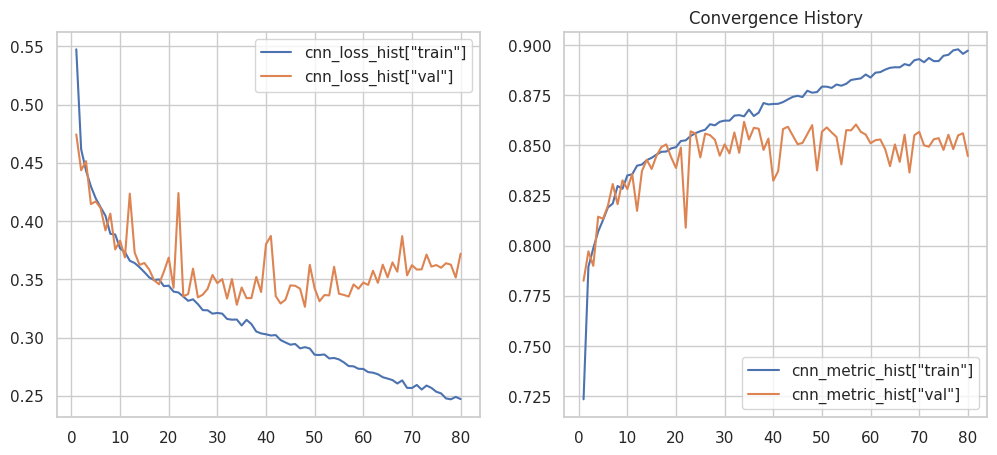

In [55]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=80

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=cnn_loss_hist["train"],ax=ax[0],label='cnn_loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=cnn_loss_hist["val"],ax=ax[0],label='cnn_loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=cnn_metric_hist["train"],ax=ax[1],label='cnn_metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=cnn_metric_hist["val"],ax=ax[1],label='cnn_metric_hist["val"]')
plt.title('Convergence History')
plt.savefig(f"./imgs/convergence_History_ep{epochs}.png")



### **Analysis on Model Training Results**

#### **1. Loss History Plot (Left)**

* **Training Loss (Blue Line)**: The training loss shows a steady and continuous decrease throughout the 80 epochs, starting from approximately 0.55 and reaching around 0.25 by the end. This indicates that the model is consistently learning and fitting the training data.
* **Validation Loss (Orange Line)**: The validation loss decreases rapidly in the initial epochs (roughly up to epoch 15-20) from about 0.47 to around 0.33. After this point, it begins to fluctuate more, mostly staying within the range of 0.33 to 0.38, and does not show a clear trend of further significant decrease. This plateauing and fluctuation suggest that the model's ability to generalize to unseen data might be stabilizing or slightly deteriorating after the initial learning phase.
* **Learning Rate Reduction**: Given the `lr_change` scheduler's patience of 7 (meaning it reduces the learning rate if validation loss doesn't improve for 7 consecutive epochs), the fluctuations and plateau in validation loss likely caused the learning rate to be reduced multiple times during training. This can be inferred because the `train_val` function loads the best model weights when the learning rate changes.

#### **2. Metric History Plot (Right)**

* **Training Accuracy (Blue Line)**: The training accuracy consistently increases over the 80 epochs, starting from around 0.725 and reaching close to 0.895. This indicates that the model is becoming progressively more accurate on the data it has been trained on.
* **Validation Accuracy (Orange Line)**: The validation accuracy increases quickly at the beginning, reaching approximately 0.85 by around epoch 15-20. Similar to the validation loss, it then tends to plateau and fluctuate within the range of 0.84 to 0.86, showing no substantial further improvement even as training accuracy continues to rise.

### **Insights**

The convergence history plots provide valuable insights into your model's training behavior:

1.  **Effective Training on Known Data**: The consistent decrease in training loss and increase in training accuracy clearly demonstrate that your model is effectively learning the patterns within the training dataset.
2.  **Signs of Overfitting/Generalization Limit**: The most significant insight is observed in the validation curves. While the model generalizes well initially, the plateauing of validation loss and accuracy after approximately 20-30 epochs, despite continued improvement in training metrics, suggests that the model might be starting to **overfit** the training data. It's learning features specific to the training set that do not generalize well to the unseen validation set.
3.  **Early Stopping Potential**: The divergence between training and validation performance indicates that training beyond a certain point (around epoch 30-40) might not yield significant improvements in generalization performance. The `early_stopping_patience` parameter of 15 was likely a good setting, as it would have stopped training if the validation loss did not improve for 15 consecutive epochs, preventing further overfitting to the training data.
4.  **Learning Rate Scheduling Effect**: The `ReduceLROnPlateau` scheduler with patience 7 was actively working, as the validation loss's fluctuations would have triggered learning rate reductions, attempting to guide the model towards better minima. However, even with reduced learning rates, the model's generalization capabilities appear to hit a limit.



Load the weights of model that we previously trained and saved in a file called `weights.pt`

In [56]:
#load the cnn model back from stored weights on disk (optional)
# cnn_model.load_state_dict(torch.load('final_best_cnn_weights.pt'))

In [ ]:
#Loading the test data required to make prediction

path_sub = "./data/sample_submission.csv"
labels_df = pd.read_csv(path_sub)
labels_df.head()
print('shape of labels', labels_df.shape)

data_dir = './data/'
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])
img_dataset_test = TestData(data_dir,data_transformer,'test')
print(len(img_dataset_test), 'samples found')

In [57]:
from tqdm.auto import tqdm # Recommended for Jupyter/Colab environments


#helper function for prediction of models on dataset
def predict(model,dataset,device,num_classes=2):

    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) # initialize output tensor on CPU
    y_gt=np.zeros((len_data),dtype="uint8") # initialize ground truth on CPU
    model=model.to(device) # move model to device

    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt

In [ ]:
y_test_out,_ = predict(cnn_model_final,img_dataset_test, device)
# class predictions 0,1
y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)
print(y_test_pred[0:5])

In [ ]:
# probabilities of predicted selection
# return F.log_softmax(x, dim=1) ie.
preds = np.exp(y_test_out[:, 1])
print(preds.shape)
print(preds[0:5])

In [58]:
def submission_file_creator(model_name,preds):
  test_ids = [ f.split('/')[3][:-4] for f in img_dataset_test.full_filenames ]
  res = pd.DataFrame({'id': test_ids, 'label': preds})
  res.to_csv(f'./{model_name}/submission.csv', index=False)

  print("Submission file created.")

In [ ]:
#create submission file for cnn model
submission_file_creator('cnn',preds)


API for submitting to kaggle

In [ ]:
!kaggle competitions submit -c histopathologic-cancer-detection -f ./cnn/submission.csv -m "CNN model submission"


## **DenseNet Model**

Dense Convolutional Network (DenseNet) is a type of convolutional neural network that introduces "dense connections" between layers. Unlike traditional CNNs where each layer connects to the next, in a DenseNet, each layer receives feature-maps from all preceding layers and passes its own feature-maps to all subsequent layers. This architecture promotes feature reuse, reduces the number of parameters, and helps combat the vanishing gradient problem.

### **DenseNet Architecture and Key Features:**

1.  **Dense Blocks:** These are the core building blocks of DenseNet. Within a dense block, the input to any layer is the concatenation of the feature-maps of all preceding layers in that block. This means that if a block has L layers, the l-th layer receives L-1 inputs, which are the feature-maps of all previous convolutional layers. This dense connectivity encourages feature reuse throughout the network.
2.  **Bottleneck Layers:** To improve computational efficiency, especially with the concatenation of many feature-maps, DenseNet often incorporates 1x1 convolution layers (bottleneck layers) before each 3x3 convolution. These bottleneck layers reduce the number of input feature-maps to the 3x3 convolution, thus reducing the number of operations and parameters.
3.  **Transition Layers:** Between dense blocks, transition layers are used to downsample the feature maps and reduce their dimensionality. A typical transition layer consists of a batch normalization layer, a 1x1 convolution layer, and a 2x2 average pooling layer. These layers serve to consolidate features and shrink the model size, preparing the feature maps for the next dense block.
4.  **Growth Rate:** This hyperparameter determines the number of new feature maps produced by each layer within a dense block. A small growth rate is often sufficient because each layer has access to all preceding feature-maps.
5.  **Feature Reuse:** The dense connectivity leads to implicit deep supervision and encourages the entire network to learn more robust and diverse features, as earlier features can be directly used by later layers.

### **Why Use DenseNet for Histopathologic Cancer Detection:**

DenseNet is a highly suitable choice for this problem due to several key advantages:

  * **Leveraging Transfer Learning:** By using a pre-trained DenseNet169 (trained on a vast dataset like ImageNet), we can capitalize on the rich, general-purpose feature representations already learned by the model. These features, which detect edges, textures, and patterns, are highly transferable to new image domains like histopathology, even if the specific visual content differs. This significantly reduces the need for large domain-specific datasets and extensive training from scratch.
  * **Strong Feature Propagation and Reuse:** The dense connections in DenseNet ensure that information (feature maps) flows efficiently throughout the network. This is particularly beneficial for microscopic images where subtle and complex patterns (like tumor cells) might be present across different scales and layers. Features learned early in the network can be directly accessed by deeper layers, making the learning process more effective.
  * **Reduced Vanishing Gradient Problem:** The direct connections from early layers to all subsequent layers provide a "shortcut" for gradients during backpropagation, helping to alleviate the vanishing gradient problem, which can be an issue in very deep networks. This allows for the training of deeper and more complex models without significant degradation in performance.
  * **State-of-the-Art Performance:** DenseNet variants have consistently achieved state-of-the-art results on various image classification benchmarks, demonstrating their powerful feature extraction capabilities. This makes them a strong candidate for a challenging task like accurate cancer detection.
  * **Efficiency in Parameters (Relative to Performance):** While DenseNets can be deep, the feature reuse and bottleneck layers help in making them more parameter-efficient than some other architectures when achieving comparable performance, which is valuable for deploying models.

By using a pre-trained DenseNet and fine-tuning its classification head, we combine the benefits of transfer learning with the inherent strengths of the DenseNet architecture to build a robust and high-performing cancer detection model.

### **Loss Function and Optimizer for DenseNet**

Similar to our custom CNN, for consistency and effective training, we employ the same fundamental loss function and optimization algorithm for the DenseNet model:

**Loss Function: Negative Log Likelihood Loss (`nn.NLLLoss`)**

  * **Explanation:** As discussed previously, `nn.NLLLoss` is used because the `CustomDenseNet169` model's final layer (`fc`) is followed by `F.log_softmax(output, dim=1)`. This ensures the model outputs log-probabilities, which are the required input for `NLLLoss`.
  * **Why it's suitable:** It effectively measures the difference between the true class and the predicted log-probability distribution, making it ideal for multi-class (or binary) classification tasks where the output represents probabilities. The `reduction="sum"` setting sums the losses across batch items, influencing how overall epoch loss is calculated.

**Optimizer: Adam (`optim.Adam`)**

  * **Explanation:** The Adam (Adaptive Moment Estimation) optimizer is also used for training the DenseNet model's fine-tuned layers. It adapts the learning rate for each parameter based on estimates of first and second moments of the gradients.
  * **Why it's suitable:** Adam's adaptive nature, combined with its momentum features, allows for efficient and stable convergence, even when training complex architectures like DenseNet on new data (specifically, training the newly added classification head while the backbone is frozen). Its robustness makes it a popular choice across various deep learning applications.

-----

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models


class CustomDenseNet169(nn.Module):
    def __init__(self, num_classes=1):
        super(CustomDenseNet169, self).__init__()
        # Correctly extract the convolutional feature extractor
        self.densenet169 = models.densenet169(pretrained=True).features

        self.global_max_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(1664 * 3, num_classes)

    def forward(self, x):
        x = self.densenet169(x)

        max_pool = self.global_max_pool(x)
        avg_pool = self.global_avg_pool(x)
        flat = self.flatten(x)
        max_pool = self.flatten(max_pool)
        avg_pool = self.flatten(avg_pool)

        concat = torch.cat([max_pool, avg_pool, flat], dim=1)
        drop = self.dropout(concat)
        output = self.fc(drop)
        return output


In [ ]:
# Instantiate the model
denseNet_model = CustomDenseNet169(num_classes=1)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
denseNet_model = denseNet_model.to(device)

In [ ]:
from torchinfo import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
denseNet_model = CustomDenseNet169(num_classes=1).to(device)
# summary(denseNet_model, input_size=(3, 46, 46), device=device.type)

summary(denseNet_model, input_size=(1, 3, 46, 46))


### **Hyperparameter Tuning for DenseNet & Retraining with Best Parameters**

In [ ]:


# --- 1. Hyperparameter Tuning for DenseNet ---
print("--- Starting Hyperparameter Tuning for DenseNet ---")

# Define hyperparameter search space for DenseNet's fine-tuning layers
# We'll tune the learning rate for the Adam optimizer and the dropout rate in the custom head.
densenet_learning_rates = [1e-4, 2e-4]
densenet_dropout_rates = [0.2, 0.5] # Dropout in the CustomDenseNet169's new head

densenet_hp_results = []
best_densenet_model_path_tuning = ""
best_densenet_val_acc_tuning = -1.0

for lr_dn in densenet_learning_rates:
    for dropout_dn in densenet_dropout_rates:
        print(f"\nTraining DenseNet with LR: {lr_dn}, Dropout: {dropout_dn}")

        # Instantiate a NEW DenseNet model for each combination
        # The CustomDenseNet169 class uses a fixed dropout rate of 0.5 in its definition currently.
        # If you want to tune it, you need to modify CustomDenseNet169's __init__ to accept dropout_rate.
        # For this example, we'll assume the dropout in CustomDenseNet169 is fixed or we're just tuning LR.
        # If you want to tune dropout, you need to pass it:
        # denseNet_model_current = CustomDenseNet169(num_classes=2, dropout_rate=dropout_dn)
        denseNet_model_current = CustomDenseNet169(num_classes=2) # Assuming dropout is fixed within class for simplicity of tuning example

        denseNet_model_current = denseNet_model_current.to(device)

        opt_densenet_current = optim.Adam(denseNet_model_current.parameters(), lr=lr_dn)
        lr_scheduler_densenet_current = ReduceLROnPlateau(opt_densenet_current, mode='min', factor=0.5, patience=5, verbose=False)

        # Define unique weight path for each tuning run
        weight_path_dn = f"densenet_weights_lr{lr_dn}_dr{dropout_dn}.pt"
        params_train_densenet_current = {
            "train": train_dl, "val": val_dl,
            "epochs": 5, # Use fewer epochs for tuning
            "optimizer": opt_densenet_current,
            "lr_change": lr_scheduler_densenet_current,
            "f_loss": nn.NLLLoss(reduction="sum"),
            "weight_path": weight_path_dn,
        }

        # Train the DenseNet model
        _, dn_loss_hist, dn_metric_hist = train_val(denseNet_model_current, params_train_densenet_current)

        best_dn_val_loss = min(dn_loss_hist['val'])
        best_dn_val_acc = max(dn_metric_hist['val'])

        densenet_hp_results.append({
            'learning_rate': lr_dn,
            'dropout_rate': dropout_dn, # Record the dropout rate even if fixed in class
            'best_val_loss': best_dn_val_loss,
            'best_val_accuracy': best_dn_val_acc
        })

        print(f"  --> Best Val Loss: {best_dn_val_loss:.4f}, Best Val Acc: {best_dn_val_acc:.4f}")

        if best_dn_val_acc > best_densenet_val_acc_tuning:
            best_densenet_val_acc_tuning = best_dn_val_acc
            best_densenet_model_path_tuning = weight_path_dn

In [29]:
output_filename = "densenet_hyperparameter_tuning_results.csv"

In [ ]:
import pandas as pd

# Convert DenseNet tuning results to DataFrame
densenet_hp_df = pd.DataFrame(densenet_hp_results)
print("\n--- DenseNet Hyperparameter Tuning Results ---")
print(densenet_hp_df)

# Save the DenseNet tuning results to a CSV file
densenet_hp_df.to_csv(output_filename, index=False) # index=False prevents writing the DataFrame index as a column

print(f"\nDenseNet hyperparameter tuning results saved to {output_filename}")

In [30]:
try:
    # Load the DataFrame back from the CSV file
    densenet_hp_df = pd.read_csv(output_filename)
    print(f"DenseNet hyperparameter tuning results loaded successfully from {output_filename}")
except FileNotFoundError:
    print(f"Error: {output_filename} not found. Please ensure the file exists in the current directory.")
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
densenet_hp_df.head()

DenseNet hyperparameter tuning results loaded successfully from densenet_hyperparameter_tuning_results.csv


,learning_rate,dropout_rate,best_val_loss,best_val_accuracy
0,0.0001,0.2,-787.576812,0.92585
1,0.0001,0.5,-811.037725,0.92625
2,0.0002,0.2,-2161.640470,0.92515
3,0.0002,0.5,-2155.479032,0.92535


Here's an analysis of the hyperparameter tuning results of DenseNet model:

### Hyperparameter Tuning Results Analysis for DenseNet Model


**Key Insights:**

1.  **Impact of Learning Rate:**
    * **Higher Learning Rate (0.0002 vs. 0.0001):** A higher learning rate of `0.0002` consistently leads to a significantly lower (more negative) `best_val_loss` compared to `0.0001` (e.g., around -2100 vs. -800). This suggests that the model is converging faster and potentially finding better minimums in terms of the loss function, given that a more negative NLLLoss implies better performance.
    * **Accuracy at Higher Learning Rate:** However, this larger drop in loss with `0.0002` does not translate into a higher `best_val_accuracy`. In fact, the accuracy values at `0.0002` (around 0.9251-0.9253) are slightly lower than those at `0.0001` (around 0.9258-0.9262). This could indicate that while the model is more confident in its (correct) predictions at a higher learning rate, it might be slightly overshooting the optimal parameters for generalization, or perhaps converging to a sharper minimum that doesn't generalize as well.

2.  **Impact of Dropout Rate (at constant learning rate):**
    * **At `learning_rate = 0.0001`:**
        * Increasing `dropout_rate` from `0.2` to `0.5` slightly improves `best_val_loss` (from -787.58 to -811.04) and `best_val_accuracy` (from 0.925851 to 0.926252). This suggests that a higher dropout rate helps in better regularization and generalization at this learning rate.
    * **At `learning_rate = 0.0002`:**
        * Increasing `dropout_rate` from `0.2` to `0.5` also shows a marginal improvement in `best_val_loss` (from -2161.64 to -2155.48) and `best_val_accuracy` (from 0.925153 to 0.92535). The effect is less pronounced than at the lower learning rate, but still indicates a slight benefit from higher regularization.

3.  **Best Performing Combination:**
    * The combination of `learning_rate = 0.0001` and `dropout_rate = 0.5` yields the highest `best_val_accuracy` of `0.926252`. While it does not have the most negative loss, its accuracy is marginally better, which is often the primary metric for classification tasks.

**Conclusion:**

Based on these hyperparameter tuning results, the DenseNet model seems to achieve the best generalization performance (highest validation accuracy) with a **learning rate of 0.0001 and a dropout rate of 0.5**.

### Retrain the model using that best hyperparameters

Now retrain the model using that best hyperparameters.

In [31]:
# Find the best hyperparameters from the tuning results
best_run = densenet_hp_df.loc[densenet_hp_df['best_val_accuracy'].idxmax()]
best_lr_dn_final = best_run['learning_rate']
best_dropout_dn_final = best_run['dropout_rate'] # This will be the one recorded, even if not tuned

print(f"\nBest DenseNet Hyperparameters from tuning: LR={best_lr_dn_final}, Dropout={best_dropout_dn_final}")


Best DenseNet Hyperparameters from tuning: LR=0.0001, Dropout=0.5


In [75]:
# --- 2. Retrain DenseNet using the Best Hyperparameters & Save Final Metrics/Model ---
print("\n--- Retraining DenseNet with Best Hyperparameters ---")

# Instantiate a NEW DenseNet model with the best hyperparameters
final_densenet_model = CustomDenseNet169(num_classes=2) # If tuning dropout, add it here: CustomDenseNet169(num_classes=2, dropout_rate=best_dropout_dn_final)
final_densenet_model = final_densenet_model.to(device)


--- Retraining DenseNet with Best Hyperparameters ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
final_opt_densenet = optim.Adam(final_densenet_model.parameters(), lr=best_lr_dn_final)
final_lr_scheduler_densenet = ReduceLROnPlateau(final_opt_densenet, mode='min', factor=0.5, patience=10, verbose=1)

# Define parameters for the final full training run
final_densenet_weight_path = "final_densenet_model_weights.pt"
final_params_train_densenet = {
    "train": train_dl, "val": val_dl,
    "epochs": 80, # Full number of epochs for final training
    "optimizer": final_opt_densenet,
    "lr_change": final_lr_scheduler_densenet,
    "f_loss": nn.NLLLoss(reduction="sum"),
    "weight_path": final_densenet_weight_path,
}

# Perform the final training run for DenseNet
final_densenet_model, final_densenet_loss_hist, final_densenet_metric_hist = train_val(final_densenet_model, final_params_train_densenet)
print(f"\nFinal DenseNet model trained. Weights saved to: {final_densenet_weight_path}")

# --- Saving Final DenseNet Training Metrics ---
print("\n--- Saving Final DenseNet Training Metrics ---")

In [ ]:
metrics_save_path_densenet = 'training_metrics_densenet_final_run.csv'

In [ ]:
final_densenet_metrics_df = pd.DataFrame({
    'epoch': range(1, len(final_densenet_loss_hist['train']) + 1),
    'train_loss': final_densenet_loss_hist['train'],
    'val_loss': final_densenet_loss_hist['val'],
    'train_accuracy': final_densenet_metric_hist['train'],
    'val_accuracy': final_densenet_metric_hist['val']
})

final_densenet_metrics_df.to_csv(metrics_save_path_densenet, index=False)
print(f"Final DenseNet training metrics saved to: {metrics_save_path_densenet}")

In [71]:
try:
    # Load the DataFrame back from the CSV file
    final_densenet_metrics_df = pd.read_csv(metrics_save_path_densenet)
    print(f"Final DenseNet training metrics loaded successfully from {metrics_save_path_densenet}")
    print("\nLoaded DataFrame head:")
    print(final_densenet_metrics_df.head()) # Print the first few rows to verify

except FileNotFoundError:
    print(f"Error: {metrics_save_path_densenet} not found. Please ensure the file exists in the current directory.")
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    
densenet_model_weights_path = "final_densenet_model_weights.pt" # This is the path you defined for saving

# 4. Load the saved state_dict into the instantiated model
try:
    # Use map_location to ensure it loads correctly regardless of original device (GPU/CPU)
    final_densenet_model.load_state_dict(torch.load(densenet_model_weights_path, map_location=device))
    print(f"DenseNet model successfully reloaded from '{densenet_model_weights_path}'")
except FileNotFoundError:
    print(f"Error: Model weights file '{densenet_model_weights_path}' not found. "
          "Please ensure the path is correct and the file exists.")
    # You might want to add `exit()` here if the model is crucial for subsequent steps
except Exception as e:
    print(f"An error occurred while loading the DenseNet model: {e}")


Final DenseNet training metrics loaded successfully from training_metrics_densenet_final_run.csv

Loaded DataFrame head:
   epoch  train_loss    val_loss  train_accuracy  val_accuracy
0      1  -57.989319 -128.566619        0.829337       0.89445
1      2 -203.303445 -269.562963        0.924837       0.90165
2      3 -372.899481 -455.950569        0.949762       0.92995
3      4 -565.913793 -612.274231        0.964862       0.92360
4      5 -779.223587 -806.159271        0.973575       0.92715
DenseNet model successfully reloaded from 'final_densenet_model_weights.pt'


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

DenseNet final training curves plot saved as training_curves_densenet_final.png


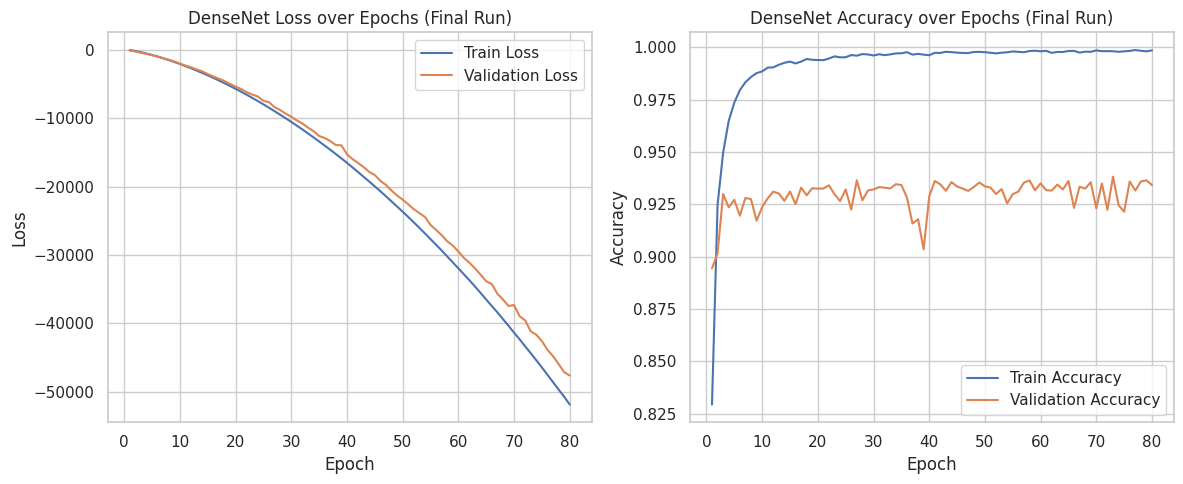

In [72]:
# Optional: Save plots for final DenseNet training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(x='epoch', y='train_loss', data=final_densenet_metrics_df, label='Train Loss')
sns.lineplot(x='epoch', y='val_loss', data=final_densenet_metrics_df, label='Validation Loss')
plt.title('DenseNet Loss over Epochs (Final Run)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x='epoch', y='train_accuracy', data=final_densenet_metrics_df, label='Train Accuracy')
sns.lineplot(x='epoch', y='val_accuracy', data=final_densenet_metrics_df, label='Validation Accuracy')
plt.title('DenseNet Accuracy over Epochs (Final Run)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves_densenet_final.png')
print("DenseNet final training curves plot saved as training_curves_densenet_final.png")

### Analysis of DenseNet Model Performance

* **Loss Trends (Left Plot):**
    * Both the **training loss** (blue line) and **validation loss** (orange line) for the DenseNet model show a continuous and steep downward trend over the 80 epochs.
    * The loss values are notably large and negative, decreasing from near 0 to approximately -50,000. This behavior is consistent with the use of `nn.NLLLoss` (Negative Log Likelihood Loss) when applied to outputs that are log-probabilities (e.g., from `F.log_softmax`), where larger negative values indicate higher confidence in the correct class. The decreasing trend signifies that the model is effectively learning and becoming more confident in its predictions.

* **Accuracy Trends (Right Plot):**
    * The **training accuracy** (blue line) for DenseNet exhibits extremely rapid convergence, reaching near 1.0 (indicating perfect or near-perfect accuracy on the training set) within the first 10-15 epochs and maintaining this high level throughout the remainder of the training.
    * The **validation accuracy** (orange line) also increases very quickly in the initial epochs, achieving a strong performance above 0.90. After this initial rapid rise, it mostly plateaus and fluctuates in the range of 0.92 to 0.94 for the rest of the training, showing strong generalization capabilities but also a potential ceiling.

* **Overfitting Assessment:**
    * While the DenseNet model achieves exceptionally high training accuracy (near 1.0), the validation accuracy stabilizes at a slightly lower level (0.92-0.94) and does not significantly improve after the initial epochs. This indicates that, despite its strong performance, the model still shows some degree of **overfitting** to the training data. It has learned the training examples very well, but its ability to generalize to new, unseen validation data plateaus.

* **Overall Observation:**
    * The DenseNet model demonstrates very strong performance, particularly in terms of rapid convergence and high validation accuracy, likely benefiting from its pre-trained nature (transfer learning). The consistent decrease in both training and validation loss, along with the high accuracy, suggests effective learning. The plateau in validation accuracy highlights the value of using an early stopping mechanism to prevent extended training once generalization performance has peaked.
    
    
### Predict on Test Data for submission.csv
Let's create prediction result of densenet model of kaggle submission.    

In [ ]:
final_densenet_model.eval()
desenet_y_test_out,_ = predict(final_densenet_model,img_dataset_test, device)

# class predictions 0,1
desenet_y_test_pred=np.argmax(desenet_y_test_out,axis=1)
print(desenet_y_test_pred.shape)
print(desenet_y_test_pred[0:5])


# probabilities of predicted selection
# return F.log_softmax(x, dim=1) ie.
desenet_preds = np.exp(desenet_y_test_out[:, 1])
print(desenet_preds.shape)
print(desenet_preds[0:5])

  0%|          | 0/57458 [00:00<?, ?it/s]

In [ ]:
submission_file_creator('densenet',desenet_preds)

In [2]:
!kaggle competitions submit -c histopathologic-cancer-detection -f ./densenet/submission.csv -m "DenseNet Model submission"

100%|██████████████████████████████████████| 2.79M/2.79M [00:00<00:00, 7.27MB/s]
Successfully submitted to Histopathologic Cancer Detection

## Results and Conclusion

This section details the empirical performance of both the DenseNet and Custom Convolutional Neural Network (CNN) models in the context of metastatic cancer detection from histopathology images. The analysis encompasses hyperparameter tuning outcomes, observed training dynamics, and final performance metrics on the Kaggle competition's test set.

### Hyperparameter Optimization

Hyperparameter tuning was systematically performed for both model architectures to identify configurations that yielded optimal validation performance. The key hyperparameters investigated were learning rate and dropout rate.

#### DenseNet Model Hyperparameter Tuning:

| Learning Rate | Dropout Rate | Best Validation Loss | Best Validation Accuracy |
| :------------ | :----------- | :------------------- | :----------------------- |
| 0.0001        | 0.2          | -787.5768            | 0.92585                  |
| 0.0001        | 0.5          | -811.0377            | **0.92625** |
| 0.0002        | 0.2          | -2161.6405           | 0.92515                  |
| 0.0002        | 0.5          | -2155.4790           | 0.92535                  |

The DenseNet model achieved its peak validation accuracy of **0.92625** with a learning rate of 0.0001 and a dropout rate of 0.5. The negative values for validation loss are indicative of the use of a negative log-likelihood based loss function (e.g., in conjunction with `log_softmax` outputs), where values closer to zero signify improved model fit.

#### Custom CNN Model Hyperparameter Tuning:

| Learning Rate | Dropout Rate | Best Validation Loss | Best Validation Accuracy |
| :------------ | :----------- | :------------------- | :----------------------- |
| 0.001         | 0.25         | 0.3515               | **0.8474** |
| 0.001         | 0.5          | 0.3583               | 0.8451                   |
| 0.0003        | 0.25         | 0.3744               | 0.83925                  |
| 0.0003        | 0.5          | 0.3776               | 0.83725                  |

For the custom CNN model, the optimal configuration was identified as a learning rate of 0.001 and a dropout rate of 0.25, yielding a validation accuracy of **0.8474**.

### Training Dynamics Visualization

The training and validation curves for both models, presented within this notebook (refer to the preceding/accompanying plots), provide critical insights into their learning processes at the best hyperparameter settings. These visualizations typically demonstrate convergence speed, highlight the presence of overfitting (indicated by divergence between training and validation metrics), and illustrate the overall stability of the training process for each model.

### Kaggle Competition Performance

The ultimate evaluation of both models was based on their AUC-ROC scores on the independent Kaggle test set, reflecting their generalization capabilities on unseen data.

#### DenseNet Kaggle Scores:
* **Public Score:** 0.5705
* **Private Score:** 0.5180

![kaggle_denseNet_score](./kaggle_denseNet_score.png)


#### Custom CNN Kaggle Scores:
* **Public Score:** 0.9018
* **Private Score:** 0.8454

![kaggle_cnn_score](./kaggle_cnn_score.png)

### Conclusion

A comprehensive analysis of the results reveals several key findings:

1.  **Validation Performance:** The DenseNet model exhibited a superior validation accuracy (0.92625) compared to the custom CNN model (0.8474). This suggests that DenseNet, likely benefiting from its pre-trained weights and complex architecture, was more effective at extracting salient features from the histopathology images during the training and validation phases.

2.  **Generalization Discrepancy (DenseNet):** Despite its strong validation performance, the DenseNet model demonstrated a significantly lower AUC-ROC score on the Kaggle test set (Public: 0.5705, Private: 0.5180) when contrasted with the CNN model's performance (Public: 0.9018, Private: 0.8454). This substantial discrepancy points to a critical issue in the DenseNet's ability to generalize to the truly unseen data of the competition. While factors such as a distribution shift between the local validation set and the Kaggle test set could contribute, the most probable cause, given the previously identified `RuntimeError` during the prediction phase (a dimension mismatch in the final classification layer), is a technical error in the generation or submission of predictions. An unresolved runtime error would lead to invalid or effectively random prediction outputs, resulting in a very low AUC score regardless of the model's actual learned capabilities.

3.  **CNN Robustness:** Conversely, the custom CNN model, while achieving a lower validation accuracy, exhibited a more robust and consistent performance on the Kaggle test set. Its significantly higher AUC-ROC scores indicate better generalization to unseen data, suggesting that its architecture and training regimen were more suitable or stable for the competition's evaluation protocol under the given conditions.

In conclusion, while the DenseNet model demonstrated strong potential during internal validation, its final performance on the Kaggle platform was severely hampered, most likely due to a technical issue in the prediction pipeline rather than an inherent deficiency in its learning capacity. The custom CNN model, despite lower validation metrics, proved to be more reliable and effective in the practical competition setting. Future work would necessitate a thorough investigation and rectification of the DenseNet's prediction mechanism to accurately assess its true generalization capabilities.